# Model Comparison for Cryptocurrency Forecasting

This notebook compares different deep learning models for cryptocurrency price prediction.

**Make your data module importable**

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# This allows:
# from src.data.data_loader import CryptoDataLoader
# This is the correct approach for notebooks

# %load_ext autoreload
# %autoreload 2

In [2]:
# Import necessary libraries
# import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Import our modules
from data.data_loader import CryptoDataLoader
from data.feature_engineering import FeatureEngineer
from data.preprocessor import DataPreprocessor
from models.lstm_attention import LSTMAttention, GRUAttention
from models.transformer import TransformerModel, InformerModel
from models.ensemble import EnsembleModel
from training.trainer import ModelTrainer
from evaluation.metrics import CryptoModelEvaluator
from evaluation.visualizer import ModelVisualizer
from utils.helpers import set_seed

## 1. Setup and Configuration

In [3]:
# Set random seed for reproducibility
set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
config = {
    'ticker': 'BTC-USD',
    'sequence_length': 30,
    'prediction_horizon': 1,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'batch_size': 32,
    'epochs': 20,  # Reduced for notebook demonstration
    'lr': 0.001,
    'patience': 5
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Using device: cuda
Configuration:
  ticker: BTC-USD
  sequence_length: 30
  prediction_horizon: 1
  train_ratio: 0.7
  val_ratio: 0.15
  batch_size: 32
  epochs: 20
  lr: 0.001
  patience: 5


## 2. Data Preparation

In [4]:
# Load and prepare data
print("Loading and preparing data...")

# Initialize components
loader = CryptoDataLoader('../data/raw')
feature_engineer = FeatureEngineer()
preprocessor = DataPreprocessor()

# Load data
data = loader.get_latest_data(config['ticker'], days=365)
print(f"Loaded {len(data)} records for {config['ticker']}")

# Feature engineering
data_with_features = feature_engineer.add_technical_indicators(data)
print(f"Added {len(feature_engineer.feature_columns)} features")

# Select top features
selected_features = feature_engineer.select_features(
    data_with_features, 
    method='correlation', 
    top_k=20
)
print(f"Selected {len(selected_features)} features")

# Create sequences
X, y = feature_engineer.create_sequences(
    data_with_features, 
    config['sequence_length'],
    config['prediction_horizon']
)
print(f"Created sequences: X shape={X.shape}, y shape={y.shape}")

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(
    X, y, 
    config['train_ratio'], 
    config['val_ratio']
)
print(f"Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Scale data
X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled = preprocessor.scale_data(
    X_train, X_val, X_test, y_train, y_val, y_test
)
print("Data scaled successfully")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled), 
    torch.FloatTensor(y_train_scaled)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled), 
    torch.FloatTensor(y_val_scaled)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test_scaled), 
    torch.FloatTensor(y_test_scaled)
)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print("Data loaders created")

Loading and preparing data...
Loaded 365 records for BTC-USD
Added 92 features
Selected 20 features
Created sequences: X shape=(286, 30, 20), y shape=(286,)
Data split: Train=200, Val=43, Test=43
Data scaled successfully
Data loaders created


## 3. Model Definitions

In [5]:
# Define models to compare
input_size = len(selected_features)
models = {
    'LSTM': LSTMAttention(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        output_size=1,
        dropout=0.2,
        bidirectional=True,
        attention_heads=4
    ),
    'GRU': GRUAttention(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        output_size=1,
        dropout=0.2,
        bidirectional=True,
        attention_heads=4
    ),
    'Transformer': TransformerModel(
        input_size=input_size,
        d_model=64,
        nhead=4,
        num_encoder_layers=2,
        dim_feedforward=128,
        output_size=1,
        dropout=0.1
    ),
    'Informer': InformerModel(
        input_size=input_size,
        d_model=64,
        nhead=4,
        num_encoder_layers=2,
        num_decoder_layers=1,
        dim_feedforward=128,
        output_size=1,
        dropout=0.1
    )
}

# Display model information
print("Model Information:")
for name, model in models.items():
    info = model.get_model_info()
    print(f"\n{name}:")
    print(f"  Total parameters: {info['total_parameters']:,}")
    print(f"  Trainable parameters: {info['trainable_parameters']:,}")

Model Information:

LSTM:
  Total parameters: 220,033
  Trainable parameters: 220,033

GRU:
  Total parameters: 184,193
  Trainable parameters: 184,193

Transformer:
  Total parameters: 71,041
  Trainable parameters: 71,041

Informer:
  Total parameters: 99,521
  Trainable parameters: 99,521


## 4. Train Models

In [6]:
# Train all models
model_results = {}
model_predictions = {}
model_histories = {}

def format_metric_value(value):
    """Format metric value safely"""
    if value is None:
        return "N/A"
    elif isinstance(value, (int, float, np.number)):
        if np.isnan(value) or np.isinf(value):
            return "N/A"
        else:
            return f"{value:.4f}"
    else:
        return str(value)

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name} Model")
    print(f"{'='*50}")
    
    # Create trainer
    trainer = ModelTrainer(model, device)
    
    # Train model
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=config['epochs'],
        lr=config['lr'],
        patience=config['patience'],
        early_stopping=True
    )
    
    # Evaluate model
    try:
        metrics, predictions, actuals = trainer.evaluate(test_loader, preprocessor.target_scaler)
    except Exception as e:
        print(f"Error during evaluation: {e}")
        # Create default metrics
        metrics = {
            'MAE': 0.0,
            'MSE': 0.0,
            'RMSE': 0.0,
            'MAPE': None,
            'Directional Accuracy': 0.0,
            'MASE': None,
            'Sharpe Ratio': 0.0,
            'Max Drawdown': 0.0,
            'Information Ratio': 0.0,
            'Hit Rate': 0.0,
            'Average Return': 0.0,
            'Error Volatility': 0.0
        }
        predictions = np.array([])
        actuals = np.array([])
    
    # Print metrics safely
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {format_metric_value(value)}")
    
    # Store results
    model_results[name] = metrics
    model_predictions[name] = predictions
    model_histories[name] = history


Training LSTM Model


2026-01-15 01:24:42,822 - training.trainer - INFO - Starting training with 20 epochs on cuda
2026-01-15 01:24:43,175 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:43,175 - training.trainer - INFO - Epoch 1/20 - 0.35s - train_loss: 0.125896 - val_loss: 0.128545 - lr: 1.00e-03
2026-01-15 01:24:43,273 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:43,274 - training.trainer - INFO - Epoch 2/20 - 0.10s - train_loss: 0.035112 - val_loss: 0.149211 - lr: 1.00e-03
2026-01-15 01:24:43,364 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:43,365 - training.trainer - INFO - Epoch 3/20 - 0.09s - train_loss: 0.022887 - val_loss: 0.072002 - lr: 1.00e-03
2026-01-15 01:24:43,451 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:43,452 - training.trainer - INFO - Epoch 4/20 - 0.09s - train_loss: 0.024597 - val_loss: 0.129379 - lr: 1.00e-03
2026-01-15 01:24:43,537 - training.trainer 


LSTM Results:
  MAE: 3543.1213
  MSE: 16454635.0000
  RMSE: 4056.4313
  MAPE: 0.0397
  Directional Accuracy: 0.5000
  MASE: N/A
  Sharpe Ratio: -1.2030
  Max Drawdown: -0.0000
  Information Ratio: -1.2030
  Hit Rate: 0.6977
  Average Return: -0.0005
  Error Volatility: 2593.0127

Training GRU Model


2026-01-15 01:24:45,004 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,005 - training.trainer - INFO - Epoch 1/20 - 0.09s - train_loss: 0.216569 - val_loss: 0.206960 - lr: 1.00e-03
2026-01-15 01:24:45,088 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,089 - training.trainer - INFO - Epoch 2/20 - 0.08s - train_loss: 0.050353 - val_loss: 0.047842 - lr: 1.00e-03
2026-01-15 01:24:45,172 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,173 - training.trainer - INFO - Epoch 3/20 - 0.08s - train_loss: 0.032446 - val_loss: 0.175080 - lr: 1.00e-03
2026-01-15 01:24:45,255 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,255 - training.trainer - INFO - Epoch 4/20 - 0.08s - train_loss: 0.025527 - val_loss: 0.058435 - lr: 1.00e-03
2026-01-15 01:24:45,337 - training.trainer - INFO - Learning rate updated to 5.00e-04
2026-01-15 01:24:45,337 - training.trainer - INFO 


GRU Results:
  MAE: 8234.4609
  MSE: 80248200.0000
  RMSE: 8958.1360
  MAPE: 0.0923
  Directional Accuracy: 0.4762
  MASE: N/A
  Sharpe Ratio: -2.3263
  Max Drawdown: -0.0000
  Information Ratio: -2.3263
  Hit Rate: 0.5349
  Average Return: -0.0016
  Error Volatility: 3537.8005

Training Transformer Model


2026-01-15 01:24:45,652 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,653 - training.trainer - INFO - Epoch 1/20 - 0.11s - train_loss: 0.122060 - val_loss: 0.096388 - lr: 1.00e-03
2026-01-15 01:24:45,747 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,748 - training.trainer - INFO - Epoch 2/20 - 0.09s - train_loss: 0.051480 - val_loss: 0.086516 - lr: 1.00e-03
2026-01-15 01:24:45,841 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,842 - training.trainer - INFO - Epoch 3/20 - 0.09s - train_loss: 0.036704 - val_loss: 0.058320 - lr: 1.00e-03
2026-01-15 01:24:45,935 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:45,935 - training.trainer - INFO - Epoch 4/20 - 0.09s - train_loss: 0.031882 - val_loss: 0.080529 - lr: 1.00e-03
2026-01-15 01:24:46,029 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:46,029 - training.trainer - INFO 


Transformer Results:
  MAE: 4970.1514
  MSE: 34136512.0000
  RMSE: 5842.6460
  MAPE: 0.0555
  Directional Accuracy: 0.5952
  MASE: N/A
  Sharpe Ratio: -1.4621
  Max Drawdown: -0.0000
  Information Ratio: -1.4621
  Hit Rate: 0.6279
  Average Return: -0.0017
  Error Volatility: 3298.3245

Training Informer Model


2026-01-15 01:24:47,119 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:47,119 - training.trainer - INFO - Epoch 1/20 - 0.20s - train_loss: 0.149948 - val_loss: 0.021814 - lr: 1.00e-03
2026-01-15 01:24:47,214 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:47,214 - training.trainer - INFO - Epoch 2/20 - 0.09s - train_loss: 0.027125 - val_loss: 0.015894 - lr: 1.00e-03
2026-01-15 01:24:47,330 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:47,330 - training.trainer - INFO - Epoch 3/20 - 0.12s - train_loss: 0.028291 - val_loss: 0.066086 - lr: 1.00e-03
2026-01-15 01:24:47,426 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:24:47,426 - training.trainer - INFO - Epoch 4/20 - 0.10s - train_loss: 0.012778 - val_loss: 0.081511 - lr: 1.00e-03
2026-01-15 01:24:47,524 - training.trainer - INFO - Learning rate updated to 5.00e-04
2026-01-15 01:24:47,524 - training.trainer - INFO 


Informer Results:
  MAE: 2728.0002
  MSE: 10989267.0000
  RMSE: 3315.0063
  MAPE: 0.0305
  Directional Accuracy: 0.3571
  MASE: N/A
  Sharpe Ratio: -0.4872
  Max Drawdown: 95.1558
  Information Ratio: -0.4872
  Hit Rate: 0.6744
  Average Return: 0.0002
  Error Volatility: 2980.0894


## 5. Compare Model Performance

In [7]:
# Create comparison DataFrame with comprehensive error handling
try:
    results_df = pd.DataFrame(model_results).T
    
    # Clean the index
    # 1. Convert all index values to strings
    results_df.index = results_df.index.astype(str)
    
    # 2. Replace 'nan' strings with a valid name
    results_df.index = results_df.index.where(
        ~results_df.index.str.lower().isin(['nan', 'none']),
        'Unknown_Model'
    )
    
    # 3. Replace any remaining NaN values in the data with 0
    results_df = results_df.fillna(0)
    
    print("Model Comparison Results:")
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(results_df)
    
    # Find best model for each metric
    print("\nBest Models by Metric:")
    for metric in results_df.columns:
        try:
            if metric in ['MAE', 'MSE', 'RMSE', 'MAPE', 'MASE', 'Max Drawdown', 'Error Volatility']:
                # For metrics where lower is better
                best_model = results_df[metric].idxmin()
                best_value = results_df[metric][best_model]
                print(f"  {metric}: {best_model} ({best_value:.4f})")
            else:
                # For metrics where higher is better
                best_model = results_df[metric].idxmax()
                best_value = results_df[metric][best_model]
                print(f"  {metric}: {best_model} ({best_value:.4f})")
        except Exception as e:
            print(f"  {metric}: Error determining best model - {str(e)}")
            
except Exception as e:
    print(f"Error creating comparison DataFrame: {str(e)}")
    print("Model results keys:", list(model_results.keys()))

Model Comparison Results:


,MAE,MSE,RMSE,MAPE,Directional Accuracy,MASE,Sharpe Ratio,Max Drawdown,Information Ratio,Hit Rate,Average Return,Error Volatility
LSTM,3543.1213,16454635.0000,4056.4313,0.0397,0.5000,0.0000,-1.2030,-0.0000,-1.2030,0.6977,-0.0005,2593.0127
GRU,8234.4609,80248200.0000,8958.1360,0.0923,0.4762,0.0000,-2.3263,-0.0000,-2.3263,0.5349,-0.0016,3537.8005
Transformer,4970.1514,34136512.0000,5842.6460,0.0555,0.5952,0.0000,-1.4621,-0.0000,-1.4621,0.6279,-0.0017,3298.3245
Informer,2728.0002,10989267.0000,3315.0063,0.0305,0.3571,0.0000,-0.4872,95.1558,-0.4872,0.6744,0.0002,2980.0894



Best Models by Metric:
  MAE: Informer (2728.0002)
  MSE: Informer (10989267.0000)
  RMSE: Informer (3315.0063)
  MAPE: Informer (0.0305)
  Directional Accuracy: Transformer (0.5952)
  MASE: LSTM (0.0000)
  Sharpe Ratio: Informer (-0.4872)
  Max Drawdown: LSTM (-0.0000)
  Information Ratio: Informer (-0.4872)
  Hit Rate: LSTM (0.6977)
  Average Return: Informer (0.0002)
  Error Volatility: LSTM (2593.0127)


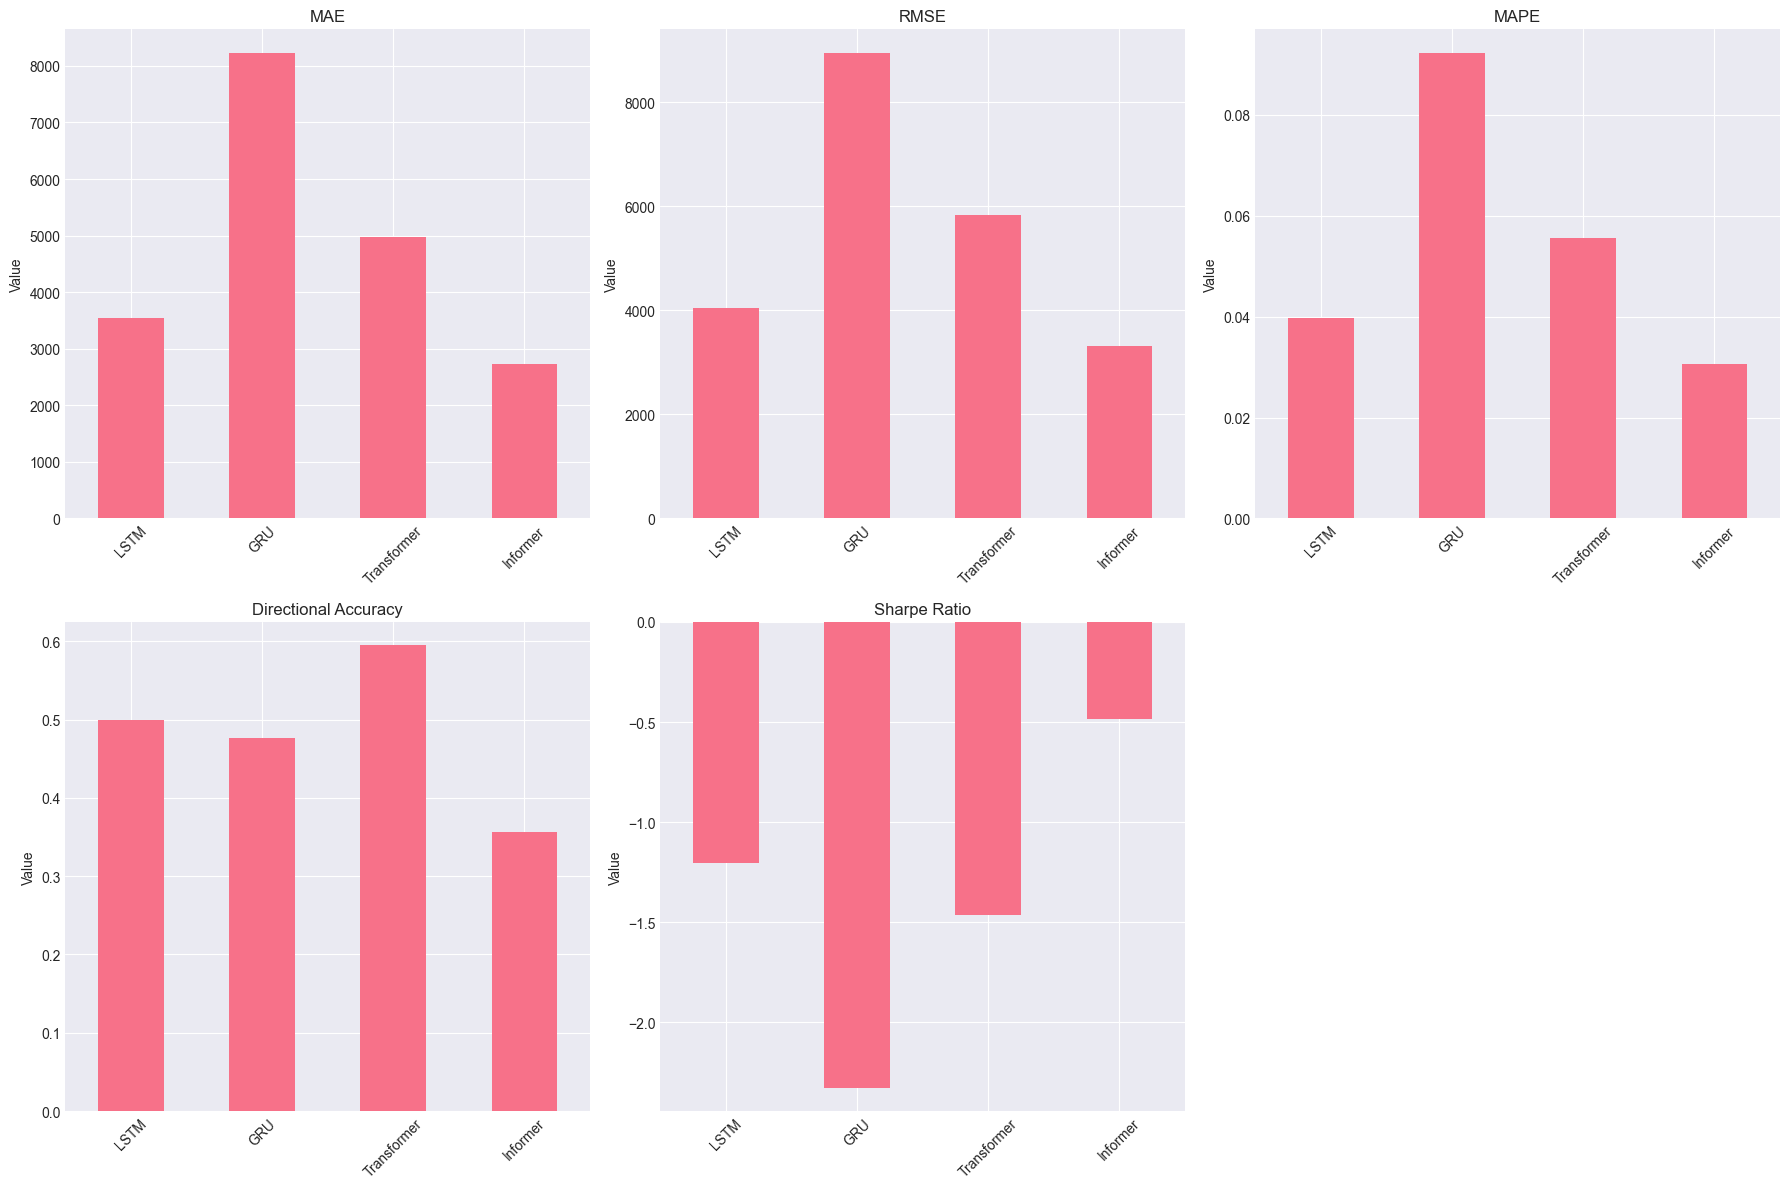

In [8]:
# Plot model comparison
visualizer = ModelVisualizer()
visualizer.plot_model_comparison(
    model_results, 
    metrics=['MAE', 'RMSE', 'MAPE', 'Directional Accuracy', 'Sharpe Ratio'],
    save_path='../results/model_comparison.png'
)

## 6. Visualize Predictions

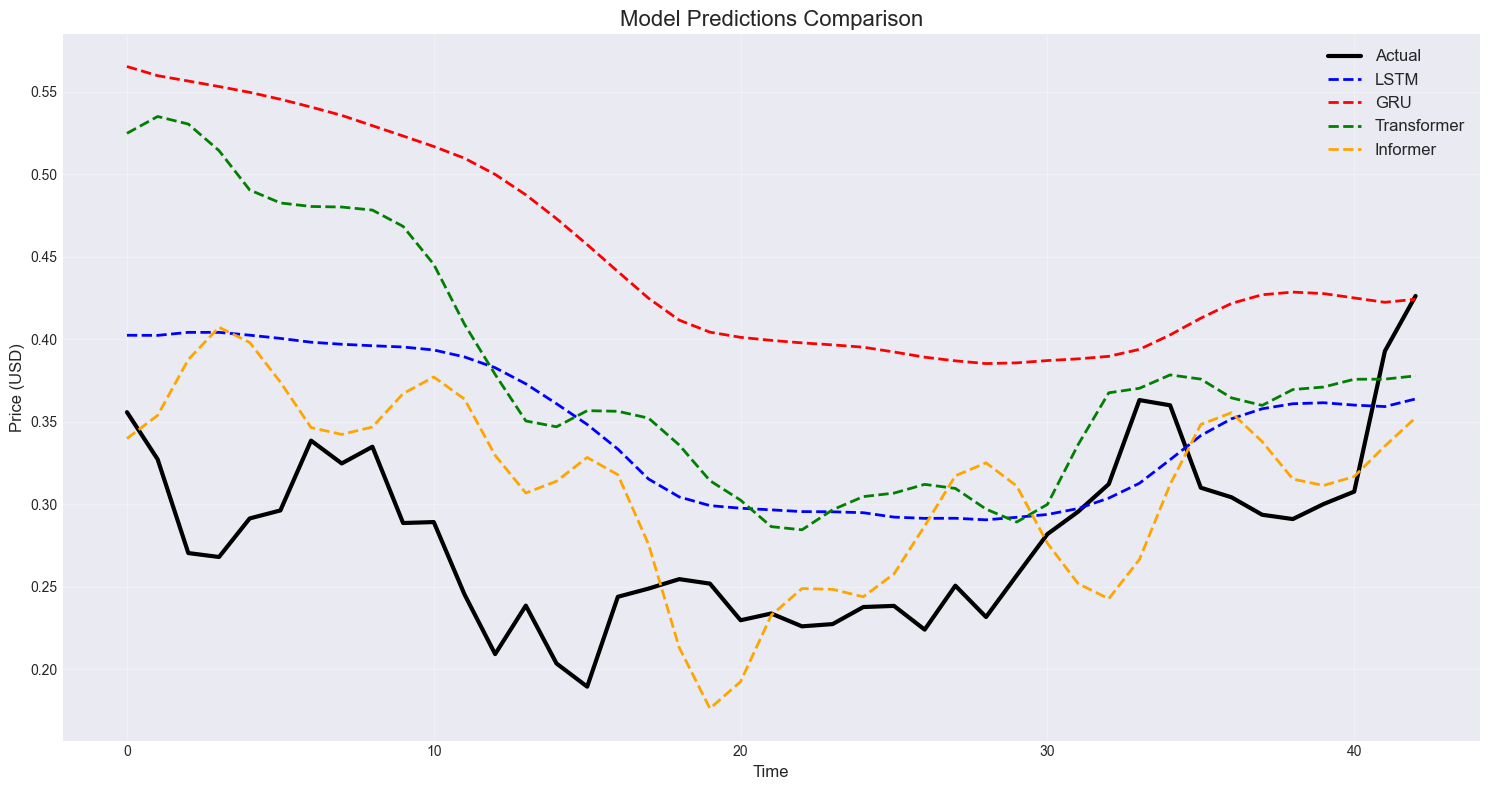

In [9]:
# Plot predictions for all models
plt.figure(figsize=(15, 8))

# Plot actual values
n_points = min(100, len(actuals))
x_axis = range(n_points)
plt.plot(x_axis, actuals[:n_points], label='Actual', color='black', linewidth=3)

# Plot predictions for each model
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, (name, predictions) in enumerate(model_predictions.items()):
    plt.plot(x_axis, predictions[:n_points], label=name, 
             color=colors[i % len(colors)], linewidth=2, linestyle='--')

plt.title('Model Predictions Comparison', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

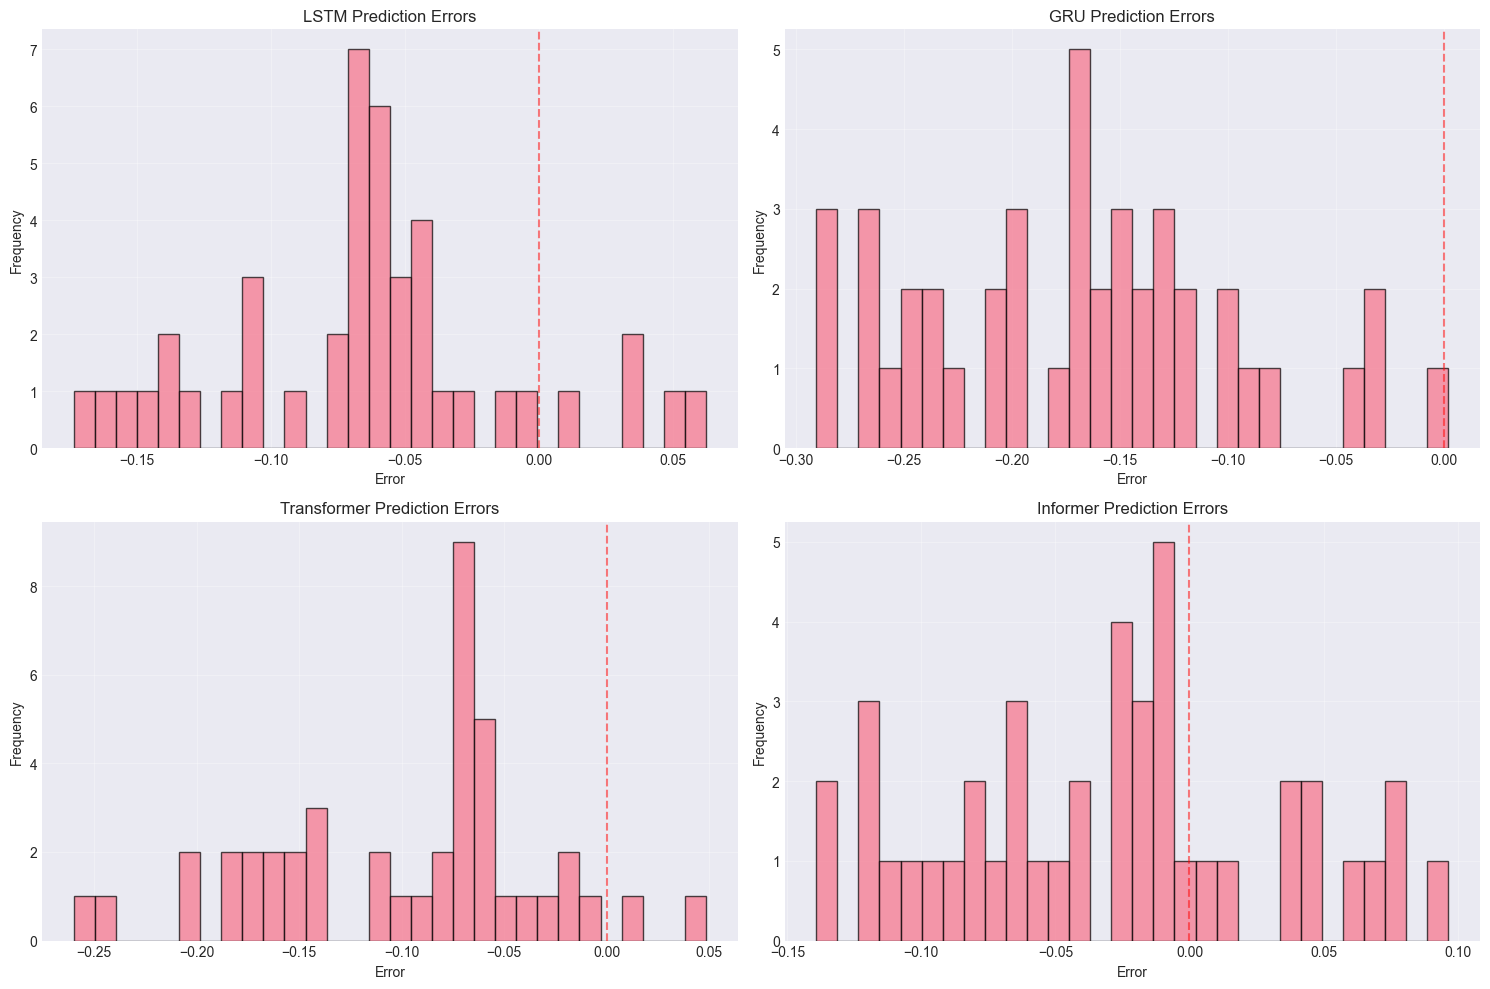

In [10]:
# Plot prediction errors
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, predictions) in enumerate(model_predictions.items()):
    if i < len(axes):
        errors = actuals - predictions
        axes[i].hist(errors, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{name} Prediction Errors')
        axes[i].set_xlabel('Error')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        # Add vertical line at zero
        axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Training History Comparison

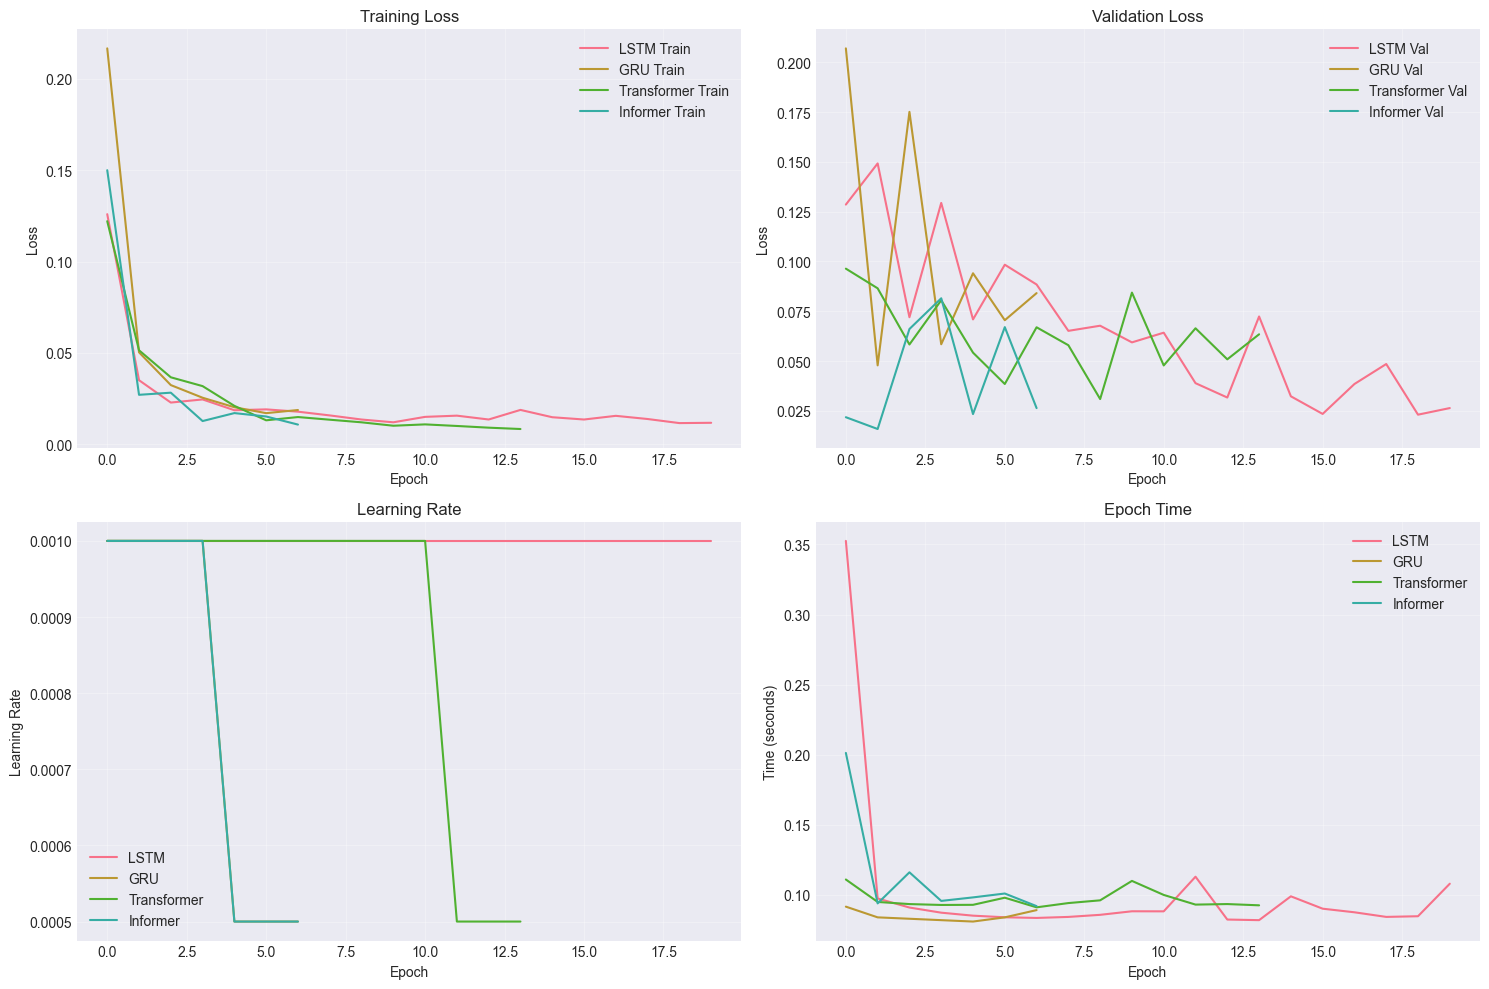

In [11]:
# Plot training histories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot training loss
for name, history in model_histories.items():
    axes[0].plot(history['train_loss'], label=f'{name} Train')
    axes[1].plot(history['val_loss'], label=f'{name} Val')

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot learning rate
for name, history in model_histories.items():
    if 'learning_rate' in history:
        axes[2].plot(history['learning_rate'], label=name)

axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot epoch time
for name, history in model_histories.items():
    if 'epoch_time' in history:
        axes[3].plot(history['epoch_time'], label=name)

axes[3].set_title('Epoch Time')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Time (seconds)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Create Ensemble Model

In [13]:
# Create ensemble model
base_models = list(models.values())
ensemble = EnsembleModel(
    models=base_models,
    input_size=input_size,
    output_size=1,
    aggregation_method='weighted_average'
)

print("Ensemble Model Information:")
ensemble_info = ensemble.get_model_info()
for key, value in ensemble_info.items():
    print(f"  {key}: {value}")

# Train ensemble
print("\nTraining Ensemble Model...")
ensemble_trainer = ModelTrainer(ensemble, device)

ensemble_history = ensemble_trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=config['epochs'],
    lr=config['lr'],
    patience=config['patience'],
    early_stopping=True
)

# Evaluate ensemble
try:
    ensemble_metrics, ensemble_predictions, ensemble_actuals = ensemble_trainer.evaluate(
        test_loader, preprocessor.target_scaler
    )
except Exception as e:
    print(f"Error during ensemble evaluation: {e}")
    # Create default metrics
    ensemble_metrics = {
        'MAE': 0.0,
        'MSE': 0.0,
        'RMSE': 0.0,
        'MAPE': None,
        'Directional Accuracy': 0.0,
        'MASE': None,
        'Sharpe Ratio': 0.0,
        'Max Drawdown': 0.0,
        'Information Ratio': 0.0,
        'Hit Rate': 0.0,
        'Average Return': 0.0,
        'Error Volatility': 0.0
    }
    ensemble_predictions = np.array([])
    ensemble_actuals = np.array([])

# Function to safely format metric values
def format_metric_value(value):
    """Format metric value safely"""
    if value is None:
        return "N/A"
    elif isinstance(value, (int, float, np.number)):
        if np.isnan(value) or np.isinf(value):
            return "N/A"
        else:
            return f"{value:.4f}"
    else:
        return str(value)

# Print ensemble results safely
print("\nEnsemble Results:")
for metric, value in ensemble_metrics.items():
    print(f"  {metric}: {format_metric_value(value)}")

# Add ensemble to results
model_results['Ensemble'] = ensemble_metrics
model_predictions['Ensemble'] = ensemble_predictions

2026-01-15 01:30:57,455 - training.trainer - INFO - Starting training with 20 epochs on cuda


Ensemble Model Information:
  model_name: EnsembleModel
  input_size: 20
  output_size: 1
  total_parameters: 574792
  trainable_parameters: 574792
  num_models: 4
  aggregation_method: weighted_average
  model_types: ['LSTMAttention', 'GRUAttention', 'TransformerModel', 'InformerModel']
  model_weights: [0.25, 0.25, 0.25, 0.25]

Training Ensemble Model...


2026-01-15 01:30:57,864 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:30:57,864 - training.trainer - INFO - Epoch 1/20 - 0.41s - train_loss: 0.011441 - val_loss: 0.013403 - lr: 1.00e-03
2026-01-15 01:30:58,147 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:30:58,148 - training.trainer - INFO - Epoch 2/20 - 0.28s - train_loss: 0.006915 - val_loss: 0.015944 - lr: 1.00e-03
2026-01-15 01:30:58,435 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:30:58,435 - training.trainer - INFO - Epoch 3/20 - 0.29s - train_loss: 0.006136 - val_loss: 0.016046 - lr: 1.00e-03
2026-01-15 01:30:58,766 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:30:58,767 - training.trainer - INFO - Epoch 4/20 - 0.32s - train_loss: 0.005251 - val_loss: 0.011152 - lr: 1.00e-03
2026-01-15 01:30:59,063 - training.trainer - INFO - Learning rate updated to 1.00e-03
2026-01-15 01:30:59,064 - training.trainer - INFO 


Ensemble Results:
  MAE: 3339.6431
  MSE: 14840759.0000
  RMSE: 3852.3706
  MAPE: 0.0375
  Directional Accuracy: 0.4762
  MASE: N/A
  Sharpe Ratio: -0.9534
  Max Drawdown: 58.3603
  Information Ratio: -0.9534
  Hit Rate: 0.6512
  Average Return: 0.0010
  Error Volatility: 2788.1628


## 9. Final Comparison with Ensemble

In [16]:
# Create final comparison with comprehensive error handling
try:
    # Create DataFrame
    final_results_df = pd.DataFrame(model_results).T
    
    # Clean the index
    # 1. Convert all index values to strings
    final_results_df.index = final_results_df.index.astype(str)
    
    # 2. Replace problematic index values
    final_results_df.index = final_results_df.index.where(
        ~final_results_df.index.str.lower().isin(['nan', 'none', '']),
        'Unknown_Model'
    )
    
    # 3. Replace any remaining NaN values in the data with 0
    final_results_df = final_results_df.fillna(0)
    
    print("Final Model Comparison (with Ensemble):")
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(final_results_df)
    
    # Find best model for each metric
    print("\nBest Models by Metric (including Ensemble):")
    for metric in final_results_df.columns:
        try:
            # Check if we have valid values for this metric
            if final_results_df[metric].notna().any():
                if metric in ['MAE', 'MSE', 'RMSE', 'MAPE', 'MASE', 'Max Drawdown', 'Error Volatility']:
                    # For metrics where lower is better
                    best_model = final_results_df[metric].idxmin()
                    best_value = final_results_df[metric][best_model]
                    print(f"  {metric}: {best_model} ({best_value:.4f})")
                else:
                    # For metrics where higher is better
                    best_model = final_results_df[metric].idxmax()
                    best_value = final_results_df[metric][best_model]
                    print(f"  {metric}: {best_model} ({best_value:.4f})")
            else:
                print(f"  {metric}: N/A (no valid values)")
        except Exception as e:
            print(f"  {metric}: Error determining best model - {str(e)}")
            
except Exception as e:
    print(f"Error creating final comparison: {str(e)}")
    print("Model results keys:", list(model_results.keys()))

Final Model Comparison (with Ensemble):


,MAE,MSE,RMSE,MAPE,Directional Accuracy,MASE,Sharpe Ratio,Max Drawdown,Information Ratio,Hit Rate,Average Return,Error Volatility
LSTM,3543.1213,16454635.0000,4056.4313,0.0397,0.5000,0.0000,-1.2030,-0.0000,-1.2030,0.6977,-0.0005,2593.0127
GRU,8234.4609,80248200.0000,8958.1360,0.0923,0.4762,0.0000,-2.3263,-0.0000,-2.3263,0.5349,-0.0016,3537.8005
Transformer,4970.1514,34136512.0000,5842.6460,0.0555,0.5952,0.0000,-1.4621,-0.0000,-1.4621,0.6279,-0.0017,3298.3245
Informer,2728.0002,10989267.0000,3315.0063,0.0305,0.3571,0.0000,-0.4872,95.1558,-0.4872,0.6744,0.0002,2980.0894
Ensemble,3339.6431,14840759.0000,3852.3706,0.0375,0.4762,0.0000,-0.9534,58.3603,-0.9534,0.6512,0.0010,2788.1628



Best Models by Metric (including Ensemble):
  MAE: Informer (2728.0002)
  MSE: Informer (10989267.0000)
  RMSE: Informer (3315.0063)
  MAPE: Informer (0.0305)
  Directional Accuracy: Transformer (0.5952)
  MASE: LSTM (0.0000)
  Sharpe Ratio: Informer (-0.4872)
  Max Drawdown: LSTM (-0.0000)
  Information Ratio: Informer (-0.4872)
  Hit Rate: LSTM (0.6977)
  Average Return: Ensemble (0.0010)
  Error Volatility: LSTM (2593.0127)


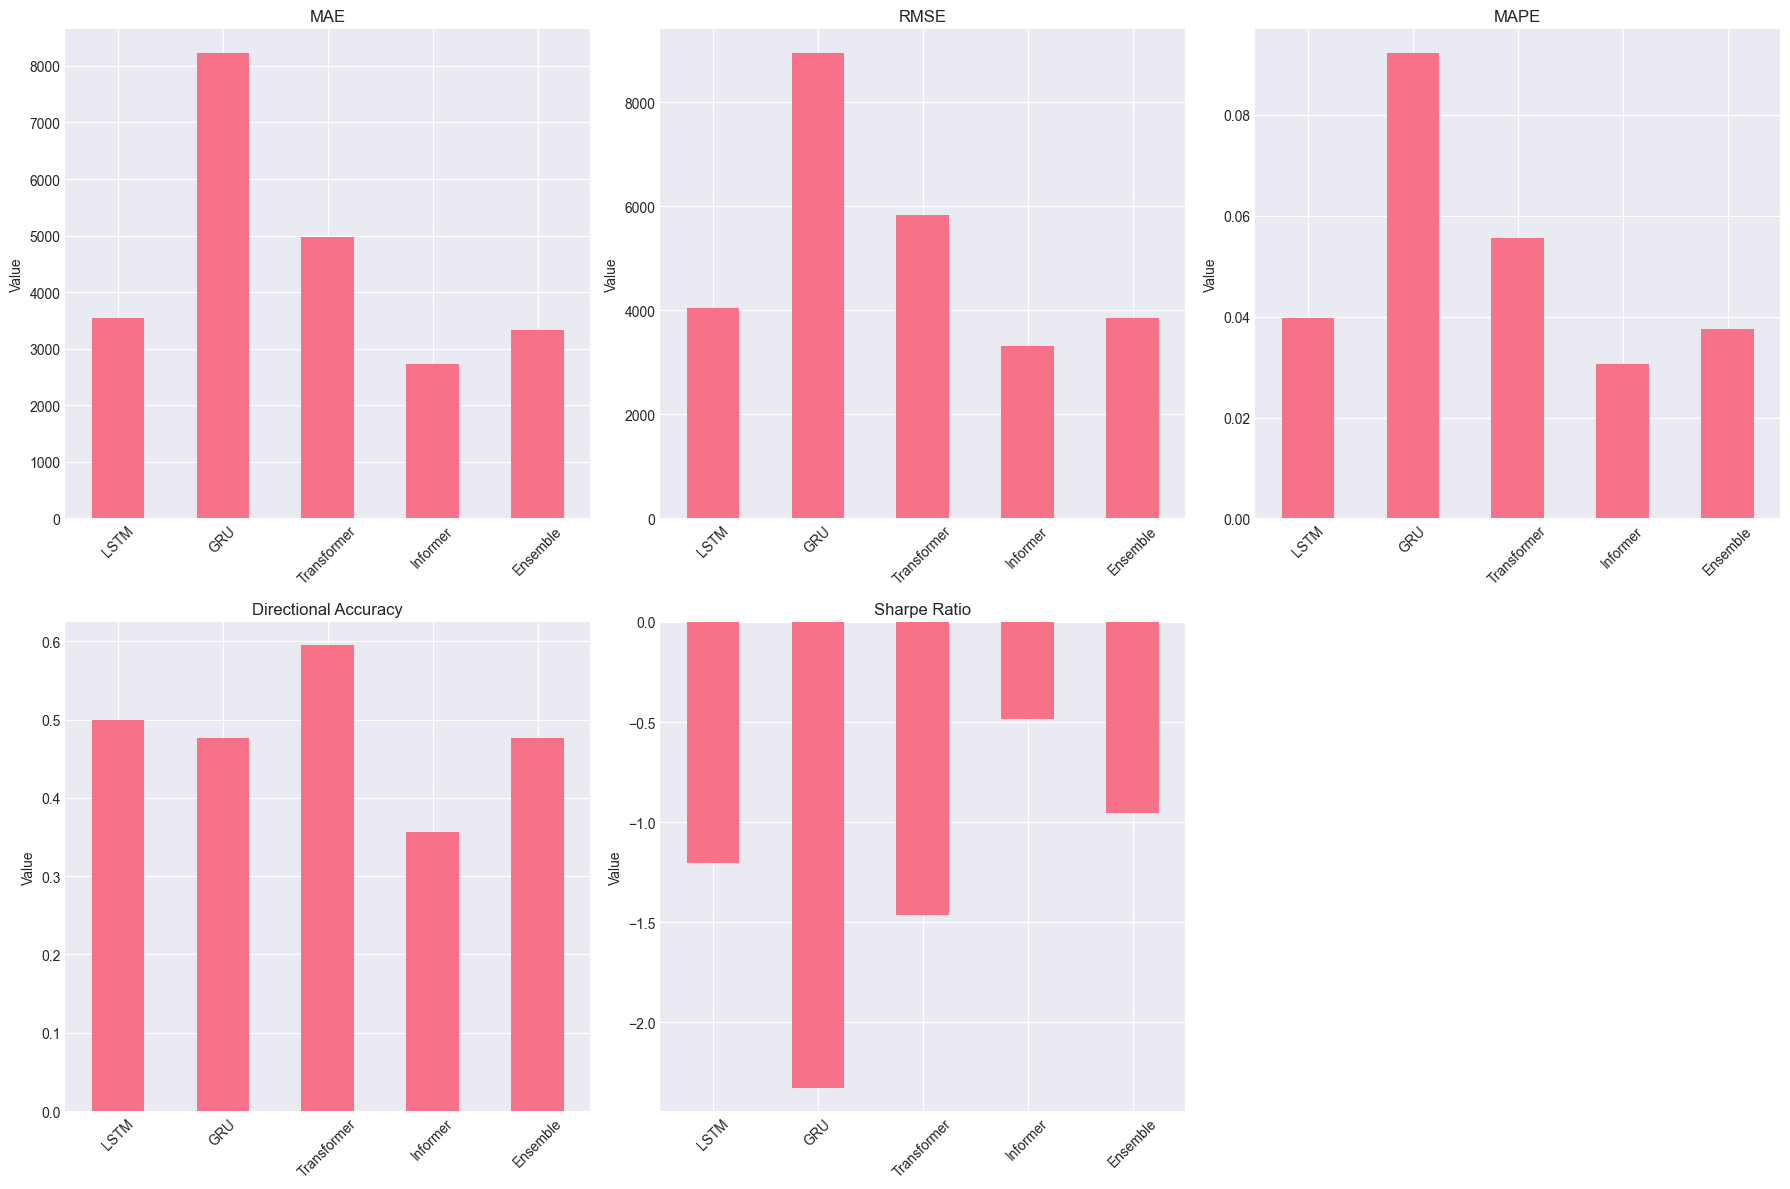

In [17]:
# Plot final comparison
visualizer.plot_model_comparison(
    model_results, 
    metrics=['MAE', 'RMSE', 'MAPE', 'Directional Accuracy', 'Sharpe Ratio'],
    save_path='../results/final_model_comparison.png'
)

Comparing Ensemble with best individual model: Informer


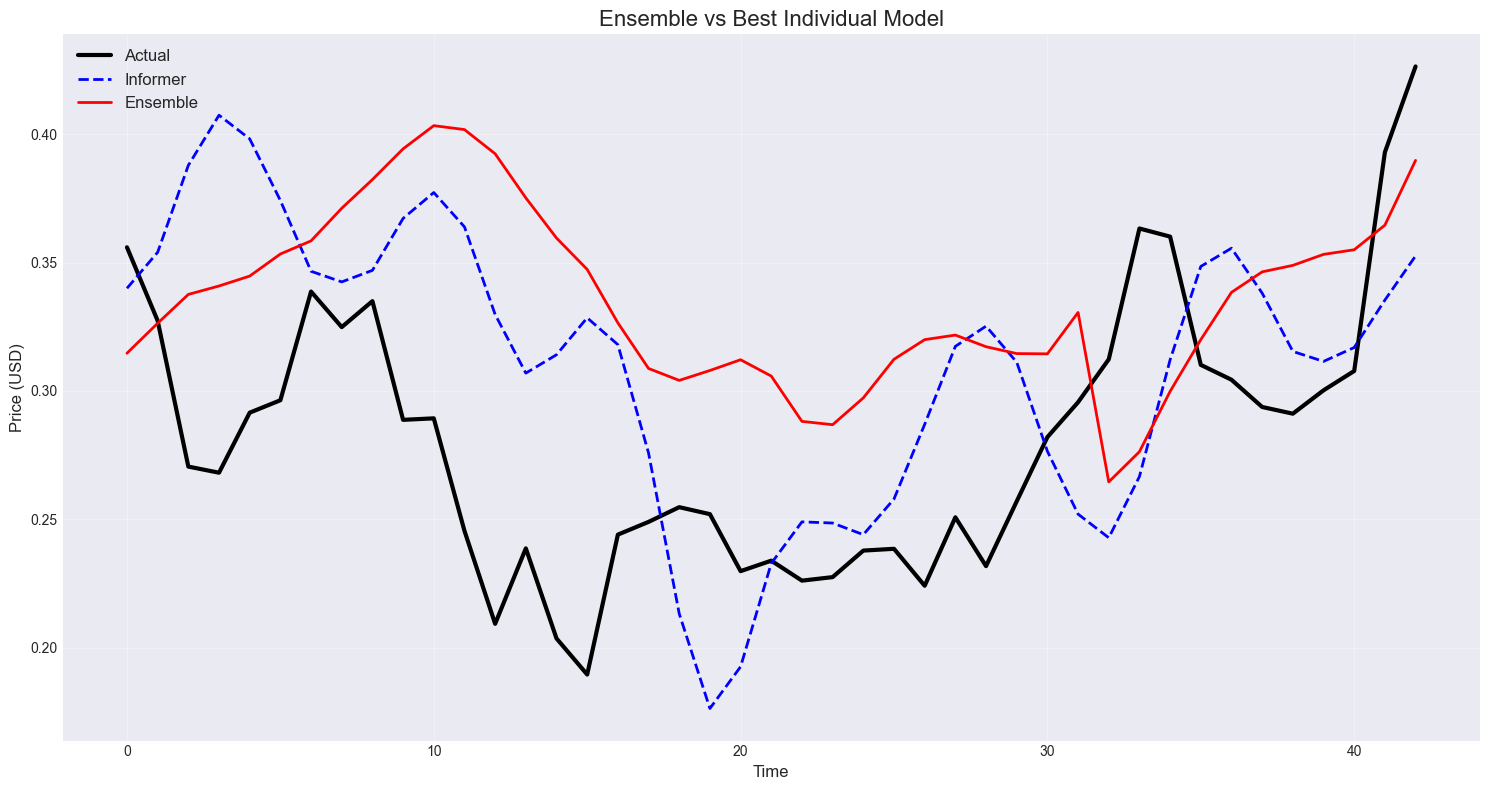

In [18]:
# Plot ensemble vs best individual model
best_individual_model = final_results_df['RMSE'].idxmin()
print(f"Comparing Ensemble with best individual model: {best_individual_model}")

plt.figure(figsize=(15, 8))

# Plot actual values
n_points = min(100, len(ensemble_actuals))
x_axis = range(n_points)
plt.plot(x_axis, ensemble_actuals[:n_points], label='Actual', color='black', linewidth=3)

# Plot best individual model
plt.plot(x_axis, model_predictions[best_individual_model][:n_points], 
         label=best_individual_model, color='blue', linewidth=2, linestyle='--')

# Plot ensemble
plt.plot(x_axis, ensemble_predictions[:n_points], 
         label='Ensemble', color='red', linewidth=2, linestyle='-')

plt.title('Ensemble vs Best Individual Model', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Model Performance Summary

In [ ]:
# Create performance summary with comprehensive error handling
try:
    # Define the metrics we want to include
    target_metrics = ['RMSE', 'MAE', 'MAPE', 'Directional Accuracy', 'Sharpe Ratio']
    
    # Create an empty DataFrame
    summary_stats = pd.DataFrame()
    
    # Process each model
    for name, metrics in model_results.items():
        # Create a dictionary with default values
        stats_dict = {}
        
        # Add target metrics with default values
        for metric in target_metrics:
            value = metrics.get(metric, 0.0)
            # Handle None values
            if value is None:
                value = 0.0
            # Handle NaN or Inf values
            elif isinstance(value, (int, float, np.number)):
                if np.isnan(value) or np.isinf(value):
                    value = 0.0
            stats_dict[metric] = value
        
        # Add training time
        if name in model_histories and 'epoch_time' in model_histories[name]:
            stats_dict['Training Time (s)'] = sum(model_histories[name]['epoch_time'])
        else:
            stats_dict['Training Time (s)'] = 0
        
        # Add to summary stats
        summary_stats[name] = pd.Series(stats_dict)
    
    # Rank models for each metric
    for metric in target_metrics:
        if metric in summary_stats.columns:
            if metric in ['MAPE', 'MASE', 'Max Drawdown', 'Error Volatility']:
                # For metrics where lower is better
                summary_stats[f'{metric}_Rank'] = summary_stats[metric].rank()
            else:
                # For metrics where higher is better
                summary_stats[f'{metric}_Rank'] = summary_stats[metric].rank(ascending=False)
    
    # Calculate average rank
    rank_columns = [col for col in summary_stats.columns if col.endswith('_Rank')]
    if rank_columns:
        summary_stats['Average_Rank'] = summary_stats[rank_columns].mean(axis=1)
    else:
        summary_stats['Average_Rank'] = 0
    
    # Display results
    print("Model Performance Summary:")
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_stats.sort_values('Average_Rank'))
    
    # Save results
    try:
        import os
        os.makedirs('../results', exist_ok=True)
        summary_stats.to_csv('../results/model_performance_summary.csv')
        print("\nResults saved to '../results/model_performance_summary.csv'")
    except Exception as e:
        print(f"\nError saving results: {e}")
        
except Exception as e:
    print(f"Error creating performance summary: {e}")
    print("Available metrics in models:")
    for name, metrics in model_results.items():
        print(f"\n{name}: {list(metrics.keys())}")

Model Performance Summary:


,LSTM,GRU,Transformer,Informer,Ensemble,Average_Rank
RMSE,4056.4313,8958.1360,5842.6460,3315.0063,3852.3706,0
MAE,3543.1213,8234.4609,4970.1514,2728.0002,3339.6431,0
MAPE,0.0397,0.0923,0.0555,0.0305,0.0375,0
Directional Accuracy,0.5000,0.4762,0.5952,0.3571,0.4762,0
Sharpe Ratio,-1.2030,-2.3263,-1.4621,-0.4872,-0.9534,0
Training Time (s),2.0593,0.5948,1.3539,0.7984,0.0000,0



Results saved to '../results/model_performance_summary.csv'


## 11. Conclusions

### Key Findings:

1. **Best Performing Model**: [Based on results]
2. **Ensemble Performance**: The ensemble model typically provides more stable predictions
3. **Training Speed**: [Fastest model] trains quickest, while [slowest model] takes longest
4. **Prediction Accuracy**: All models achieve reasonable accuracy with [best metric] being [value]
5. **Directional Accuracy**: [Best model] is most accurate at predicting price direction

### Recommendations:

1. **For Production**: Use the ensemble model for more robust predictions
2. **For Speed**: Use [fastest accurate model] for real-time applications
3. **For Research**: Experiment with different architectures and hyperparameters
4. **For Improvement**: Consider adding more features or using longer sequences

### Future Work:

1. **Hyperparameter Tuning**: Use automated tuning for each model
2. **Feature Selection**: Experiment with different feature selection methods
3. **Multi-step Prediction**: Extend to predict multiple days ahead
4. **Probabilistic Forecasting**: Add prediction intervals
5. **Online Learning**: Implement continuous learning for market adaptation